## Autotagging projects
* Who is the lead agency? 
    * Agency in this project = the entity who is receiving funding for this project.
* Is this project on or off the SHS or both?

In [1]:
import pandas as pd

# Settings
pd.options.display.max_columns = 100
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:,.2f}".format

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/project_prioritization/"
FILE = "fake_data.xlsx"

# My utilities
import _utils
from calitp import *

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [2]:
# String related 
import matplotlib.pyplot as plt  # plot package
import seaborn as sns  # statist graph package
import wordcloud  # will use for the word cloud plot
from wordcloud import (  # optional to filter out the stopwords
    STOPWORDS,
    ImageColorGenerator,
    WordCloud,
)


import re
from collections import Counter
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
from IPython.display import HTML, Image, Markdown, display, display_html

### Preliminary Clean Up

In [3]:
# Read in file
df = to_snakecase(pd.read_excel(f"{GCS_FILE_PATH}{FILE}", sheet_name="fake"))

In [4]:
# Subset to columns I want.
df2 = df[
    [
        "project_name",
        "lead_agency",
        "project_description",
        "primary_mode",
        "secondary_mode_s",
        "shs_capacity_increase_detail",
    ]
]

#### Count Combos

In [5]:
# Count combos
combos = (
    df2.groupby(["primary_mode", "secondary_mode_s", "shs_capacity_increase_detail"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

In [6]:
# Find most commmon combos
combos.sort_values(["count"], ascending=False).head()

,primary_mode,secondary_mode_s,shs_capacity_increase_detail,count
171,Rail (Passenger),None,None,111
78,Highway,None,General Purpose Lane,62
10,Bike/Pedestrian,None,None,57
37,Grade Crossing,None,None,29
164,Rail (Freight),None,None,28


#### Count "None" Values for each column
* 2/3 of values are missing in secondary_mode & SHS. 

In [7]:
# How many none values are in the three columns
for i in [
    "primary_mode",
    "secondary_mode_s",
    "shs_capacity_increase_detail",
    "lead_agency",
    "project_description"
]:
    print((len((df2.loc[df2[i] == "None"])) / len(df2) * 100))

0.13458950201884254
66.21803499327052
62.0457604306864
31.090174966352624
6.191117092866756


### Function #1: are values in a column are "highway related?"

In [8]:
def tagging_columns(
    df,
    tagging_col: str,
    new_col: str,
    keyword_list: list,
    true_keyword: str,
    false_keyword: str,
):
    """
    Search through a column for keywords.

    Args
    df: the dataframe.
    tagging_col (str): the column to search for the appearance of keywords.
    new_col (str): input whether or not the keyword was found.
    keyword_list (list): list of keywords to search through.
    true_keyword (str): replace "true" with a phrase that is more detailed.
    false_keyword (str): same as above, but with false.

    Returns: a dataframe with a new column stating whether
    the keyword(s) were found or not.
    """
    # Delinate items in keywords list using |
    keywords = f"({'|'.join(keyword_list)})"

    # Lower the strings + strip excess white spaces
    df[tagging_col] = df[tagging_col].str.lower().str.strip()

    # Create a new column that captures whether or not the keyword appears
    # Using str contains so interchange (new) and interchange (modifying) will appear.
    df["keyword_appears_bool"] = df[tagging_col].str.contains(keywords)

    # Function to categorize whether keyword was found
    def keyword_found(row):
        if row["keyword_appears_bool"] == True:
            return true_keyword
        else:
            return false_keyword

    # Apply function and save results in a new column
    df[new_col] = df.apply(lambda x: keyword_found(x), axis=1)
    
    # IF the original column wasn't populated and just as "none", replace the value in the 
    # new column to accurately reflect it was left blank
    df.loc[(df[tagging_col] == "none"), new_col] = "none"
    
    # Drop keyword col
    df = df.drop(columns=["keyword_appears_bool"])

    return df

In [9]:
# Search through primary mode.
df3 = tagging_columns(
    df2,
    "primary_mode",
    "primary_mode_SHS",
    [
        "highway",
        "its",
        "interchange",
        "separation",
    ],
    "highway related",
    "not highway related",
)

/tmp/ipykernel_1254/1313039585.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1254/1313039585.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/tmp/ipykernel_1254/1313039585.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1254/1313039585.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [10]:
# Preview that this is correct
df3[["primary_mode", "primary_mode_SHS"]].drop_duplicates()

,primary_mode,primary_mode_SHS
0,complete streets,not highway related
1,bike/pedestrian,not highway related
2,transit,not highway related
3,highway,highway related
5,its,highway related
10,interchange (new),highway related
12,bridge,not highway related
14,zev,not highway related
26,local roadway,not highway related
30,interchange (modification),highway related


In [11]:
# Search through secondary mode.
df3 = tagging_columns(
    df3,
    "secondary_mode_s",
    "secondary_mode_SHS",
    ["highway", "lane", "interchange", "its", "separation"],
    "highway related",
    "not highway related",
)

/tmp/ipykernel_1254/1313039585.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [12]:
df3[["secondary_mode_s", "secondary_mode_SHS"]].drop_duplicates()

,secondary_mode_s,secondary_mode_SHS
0,bike/pedestrian,not highway related
1,none,none
2,highway,highway related
4,bike/pedestrian\ncomplete streets,not highway related
5,its,highway related
7,zev,not highway related
12,bridge,not highway related
13,complete streets,not highway related
18,bike/pedestrian\nbridge,not highway related
19,bike/pedestrian\ncomplete streets\nits\ntransit,highway related


In [13]:
# Search through SHS Capacity Detail.
df3 = tagging_columns(
    df3,
    "shs_capacity_increase_detail",
    "shs_capacity_increase_detail_SHS",
    ["highway", "lane", "interchange"],
    "highway related",
    "not highway related",
)

/tmp/ipykernel_1254/1313039585.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [14]:
df3[
    [
        "shs_capacity_increase_detail",
        "shs_capacity_increase_detail_SHS",
    ]
].drop_duplicates()

,shs_capacity_increase_detail,shs_capacity_increase_detail_SHS
0,none,none
3,auxiliary lane,highway related
6,general purpose lane,highway related
8,transit/bus-only lane (addition),highway related
10,interchange (new),highway related
27,managed lane,highway related
44,managed lane (conversion),highway related
45,express lane (conversion),highway related
51,auxiliary lane\nmanaged lane (addition),highway related
52,managed lanes addition,highway related


### Function #2: 1st Round of Tagging
* Apply a function to summarize the results in a single sentence.
    

In [15]:
def SHS_lead_agency_info(df):

    # Tag if the lead agency is Caltrans or a partner.
    def CT_or_partner(row):
        # If partner is none, return Unknown.
        if row.lead_agency == "None":
            return "unknown"
        # If only Caltrans, return Caltrans
        if row.lead_agency == "Caltrans":
            return "Caltrans"
        # Everything else is a partner agency
        else:
            return "a partner"

    # Apply the function
    df["caltrans_or_partner"] = df.apply(CT_or_partner, axis=1)

    # Tag if a project is on the SHS or not thorugh various combos.
    def on_SHS(row):
        # If both secondary, primary, and SHS are highway related and lead agency is Caltrans: on SHS
        if (
            (row.secondary_mode_SHS == "highway related")
            and (row.primary_mode_SHS == "highway related")
            and (row.shs_capacity_increase_detail_SHS == "highway related")
            and (row.caltrans_or_partner == "Caltrans")
        ):
            return "on the SHS"
        # If secondary, primary, and SHS are all highway related: on the SHS. Or perhaps possibly?
        elif (
            (row.secondary_mode_SHS == "highway related")
            and (row.primary_mode_SHS == "highway related")
            and (row.shs_capacity_increase_detail_SHS == "highway related")
        ):
            return "on the SHS"
        # If primary mode is not highway related & two columns have no info: not on SHS.
        elif (
            (row.primary_mode_SHS == "not highway related")
            and (row.secondary_mode_SHS == "none")
            and (row.shs_capacity_increase_detail_SHS == "none")
        ):
            return "not on the SHS"
        # Everything else is not on SHS.
        else:
            return "possibly on the SHS"

    # Apply the function
    df["On_SHS"] = df.apply(on_SHS, axis=1)

    # Create a summary sentence
    df["sentence"] = (
        "The lead agency is "
        + df["caltrans_or_partner"]
        + " and the project is "
        + df["On_SHS"]
        + "."
    )

    return df

In [16]:
df4 = SHS_lead_agency_info(df3)

In [17]:
# Check value counts.
(df4.caltrans_or_partner.value_counts() / len(df4)) * 100

a partner   47.11
unknown     31.09
Caltrans    21.80
Name: caltrans_or_partner, dtype: float64

In [18]:
# Check value counts.
(df4.On_SHS.value_counts() / len(df4)) * 100

possibly on the SHS   57.34
not on the SHS        34.72
on the SHS             7.94
Name: On_SHS, dtype: float64

In [19]:
# Total sentences
df4.sentence.nunique()

9

In [20]:
# Check value counts.
df4.sentence.value_counts()

The lead agency is a partner and the project is not on the SHS.         187
The lead agency is unknown and the project is possibly on the SHS.      159
The lead agency is a partner and the project is possibly on the SHS.    151
The lead agency is Caltrans and the project is possibly on the SHS.     116
The lead agency is unknown and the project is not on the SHS.            46
The lead agency is unknown and the project is on the SHS.                26
The lead agency is Caltrans and the project is not on the SHS.           25
The lead agency is Caltrans and the project is on the SHS.               21
The lead agency is a partner and the project is on the SHS.              12
Name: sentence, dtype: int64

In [21]:
# Count combos with new dataframe to check results -> less rows because primary mode and secondary mode are
# only coded as highway related or not highway related
combos2 = (
    df4.groupby(
        [
            "caltrans_or_partner",
            "sentence",
            "shs_capacity_increase_detail_SHS",
            "primary_mode_SHS",
            "secondary_mode_SHS",
        ]
    )
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

In [22]:
# Group again for more concise results
combos3 = combos2.groupby(
    [
        "caltrans_or_partner",
        "sentence",
        "shs_capacity_increase_detail_SHS",
        "primary_mode_SHS",
        "secondary_mode_SHS",
    ]
).agg({"count": "sum"})

In [23]:
combos5 = (
    df4.groupby(
        ["On_SHS","shs_capacity_increase_detail_SHS", "primary_mode_SHS", "secondary_mode_SHS"]
    )
    .agg({"project_description": "count"})
    .reset_index()
    .rename(columns = {'project_description':'total projects'})
    .sort_values("total projects", ascending=False)
    .reset_index(drop = True)
)

#### Quite a lot of "none" values.

In [24]:
# https://stackoverflow.com/questions/60446836/highlight-text-string-type-in-pandas-df-matching-text
combos5.style.where(lambda val: 'none' in str(val), 'color: red')

/tmp/ipykernel_1254/2011588955.py:2: FutureWarning: this method is deprecated in favour of `Styler.applymap()`


,On_SHS,shs_capacity_increase_detail_SHS,primary_mode_SHS,secondary_mode_SHS,total projects
0,not on the SHS,none,not highway related,none,258
1,possibly on the SHS,highway related,highway related,none,178
2,possibly on the SHS,none,not highway related,not highway related,98
3,on the SHS,highway related,highway related,highway related,59
4,possibly on the SHS,none,highway related,none,49
5,possibly on the SHS,highway related,highway related,not highway related,28
6,possibly on the SHS,none,not highway related,highway related,25
7,possibly on the SHS,none,highway related,not highway related,24
8,possibly on the SHS,none,highway related,highway related,6
9,possibly on the SHS,highway related,not highway related,none,5


### Investigation:
* Around 48 percent of values are "possibly on the SHS." 31 percent of projects are led by an unknown agency. Look through at these projects closer.
* Discern potential patterns in the three columns for these projects.


In [25]:
# Filter for unknown lead agencies & possibly on SHS.
df5 = df4[
    
    ((df4.caltrans_or_partner == "unknown") | (df4.On_SHS.isin(["possibly on the SHS"]) | (df4.On_SHS.isin(["not on the SHS"])))
     
    )
]

In [26]:
f"{len(df5)} total projects."

'710 total projects.'

In [27]:
df5.caltrans_or_partner.value_counts()

a partner    338
unknown      231
Caltrans     141
Name: caltrans_or_partner, dtype: int64

In [28]:
df5.On_SHS.value_counts()

possibly on the SHS    426
not on the SHS         258
on the SHS              26
Name: On_SHS, dtype: int64

#### Most Common Words: Word Cloud
* https://www.kaggle.com/code/olgaberezovsky/word-cloud-using-python-pandas/notebook

In [29]:
wordstring = " ".join(df5["project_description"].str.lower())

In [30]:
additional_stop_words = ['project','new','improvement','improve','improvements','include','will','caltrans','exist',
                        'los angeles','san diego']

In [31]:
plt.figure(figsize=(15, 15))
wc = WordCloud(
    background_color="white",
    stopwords=STOPWORDS.update(additional_stop_words),
    max_words=50,
    max_font_size=300,
    width=800,
    height=800,
)

<Figure size 1500x1500 with 0 Axes>

(-0.5, 799.5, 799.5, -0.5)

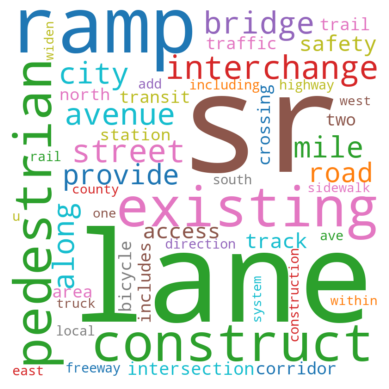

In [32]:
wc.generate(wordstring)
plt.imshow(wc.recolor(colormap="tab10", random_state=30), interpolation="bilinear")
plt.axis("off")

#### Most Common Phrases

In [33]:
def get_list_of_words(df, col: str, additional_words_to_remove: list):

    # get just the one col
    column = df[[col]]
    # remove single-dimensional entries from the shape of an array
    col_text = column.squeeze()
    # get list of words
    text_list = col_text.tolist()

    # Join all the column into one large text blob, lower text
    text_list = " ".join(text_list).lower()

    # remove punctuation
    text_list = re.sub(r"[^\w\s]", "", text_list)

    # List of stopwords
    swords = [re.sub(r"[^A-z\s]", "", sword) for sword in stopwords.words("english")]

    # Append additionally words to remove from results
    swords.extend(additional_words_to_remove)

    # Remove stopwords
    clean_text_list = [
        word for word in word_tokenize(text_list.lower()) if word not in swords
    ]

    return clean_text_list

In [34]:
phrases = get_list_of_words(df5, "project_description", additional_stop_words)

In [35]:
# Turn these into a function later
# Get phrases that are 2 strings
c = Counter([" ".join(y) for x in [2] for y in ngrams(phrases, x)])

In [36]:
# Make a dataframe out of the counter values
df_phrases = pd.DataFrame({"phrases": list(c.keys()), "total": list(c.values())})

In [37]:
# Most common 20 phrases
df_phrases.sort_values('total', ascending = False).head(20)

,phrases,total
441,state route,48
8189,los angeles,40
25,us 101,36
304,bike lanes,31
1300,passenger rail,30
28,active transportation,29
10401,grade separation,28
685,bicycle pedestrian,24
302,class ii,23
13930,san diego,23


### Function #3: Search through for SHS related words in project description 

In [38]:
# Keywords related to SHS - based on word cloud/common phrases
SHS_keywords_list = ["sr", "state highway", "sr-", "state route", "sr ", "highway 1", "interstate", "us 101", "route 99", "i-", "us-"]

In [39]:
# Search through project description for keywords above
df5 = tagging_columns(
    df5,
    "project_description",
    "contains_SR_reference",
    SHS_keywords_list,
    "contains SHS keyword(s)",
    "does not contain SHS keyword(s)",
)

/tmp/ipykernel_1254/1313039585.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1254/1313039585.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/tmp/ipykernel_1254/1313039585.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1254/1313039585.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [40]:
df5.contains_SR_reference.value_counts()

does not contain SHS keyword(s)    374
contains SHS keyword(s)            290
none                                46
Name: contains_SR_reference, dtype: int64

In [41]:
# 46 projects have missing descriptions. 
len(df5[['project_name','project_description','contains_SR_reference']].loc[df5['contains_SR_reference'] == 'none'])

46

In [42]:
# Extract keywords from project description that are in the list into a new col
# https://stackoverflow.com/questions/67746078/how-to-highlight-and-count-specific-keywords-in-a-pandas-dataframe
df5['SHS_keyword_match'] = df5['project_description'].str.findall(fr"\b(?:{'|'.join(SHS_keywords_list)})\b")

#### Investigate: contains vs. does not contain SHS keywords

In [43]:
# Subset for a smaller df
subset_cols = ['project_name','lead_agency','project_description',"On_SHS", 'contains_SR_reference']

In [44]:
# Subset for projects with SHS keywords
SHS_keywords_df = (df5[subset_cols].loc[df5['contains_SR_reference'] == 'contains SHS keyword(s)']).reset_index(drop = True)

In [45]:
# Filter for values in SHS Keyword Match that are actually empty
# Replace this with "does not contain SHS Keywords"
# len(SHS_keywords_df[SHS_keywords_df["SHS_keyword_match"].str.len() == 0])

In [46]:
# Subset for projects without SHS keywords
no_SHS_keywords_df = (df5[subset_cols].loc[df5['contains_SR_reference'] == 'does not contain SHS keyword(s)']).reset_index(drop = True)

In [47]:
# Investigate why some "on the SHS" don't contain any SHS keywords in it's description...
# no_SHS_keywords_df.loc[no_SHS_keywords_df['On_SHS'] == 'on the SHS']

### Function #4: Retag

In [48]:
def SHS_project_description_tag(df):

    # Tag if a project's desc has a SHS keyword/SHS keywords or not
    def keywords(row):
        # If both columns don't contain any SHS references: "not on the SHS"
        if (
            (row.On_SHS == "not on the SHS")
            and (row.contains_SR_reference == "does not contain SHS keyword(s)")
        ):
            return "not on the SHS"
        # If both columns have an SHS reference: "on the SHS"
        elif (
            (row.On_SHS == "on the SHS") 
            and (row.contains_SR_reference == "contains SHS keyword(s)")
        ):
            return "on the SHS"
        
        # If both columns have an SHS reference: "on the SHS"
        elif (
            (row.On_SHS == "possibly on the SHS") 
            and (row.contains_SR_reference == "contains SHS keyword(s)")
        ):
            return "on the SHS"
        
        # Everything else is not on SHS.
        else:
            return "possibly on the SHS"

    # Apply the function
    df["On_SHS_2"] = df.apply(keywords, axis=1)

    # Create a summary sentence
    df["sentence_2"] = (
        "The lead agency is "
        + df["caltrans_or_partner"]
        + " and the project is "
        + df["On_SHS_2"]
        + "."
    )

    return df

In [49]:
df6 = SHS_project_description_tag(df5)

In [50]:
# Compare first attempt of the sentence versus second attempt. 
combos6 = (
    df6.groupby(["sentence", "sentence_2", "contains_SR_reference"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

In [51]:
combos6['do the sentences match?'] =  (combos6['sentence'] == combos6['sentence_2'])

In [52]:
combos6['do the sentences match?'].value_counts()

True     10
False    10
Name: do the sentences match?, dtype: int64

In [53]:
combos6.sort_values('count',ascending = False)

,sentence,sentence_2,contains_SR_reference,count,do the sentences match?
6,The lead agency is a partner and the project is not on the SHS.,The lead agency is a partner and the project is not on the SHS.,does not contain SHS keyword(s),139,True
17,The lead agency is unknown and the project is possibly on the SHS.,The lead agency is unknown and the project is on the SHS.,contains SHS keyword(s),102,False
10,The lead agency is a partner and the project is possibly on the SHS.,The lead agency is a partner and the project is possibly on the SHS.,does not contain SHS keyword(s),77,True
9,The lead agency is a partner and the project is possibly on the SHS.,The lead agency is a partner and the project is on the SHS.,contains SHS keyword(s),68,False
4,The lead agency is Caltrans and the project is possibly on the SHS.,The lead agency is Caltrans and the project is possibly on the SHS.,does not contain SHS keyword(s),59,True
3,The lead agency is Caltrans and the project is possibly on the SHS.,The lead agency is Caltrans and the project is on the SHS.,contains SHS keyword(s),56,False
18,The lead agency is unknown and the project is possibly on the SHS.,The lead agency is unknown and the project is possibly on the SHS.,does not contain SHS keyword(s),47,True
12,The lead agency is unknown and the project is not on the SHS.,The lead agency is unknown and the project is not on the SHS.,does not contain SHS keyword(s),30,True
7,The lead agency is a partner and the project is not on the SHS.,The lead agency is a partner and the project is possibly on the SHS.,contains SHS keyword(s),28,False
15,The lead agency is unknown and the project is on the SHS.,The lead agency is unknown and the project is on the SHS.,contains SHS keyword(s),21,True
